In [1]:
from pathlib import Path
import json

%matplotlib inline
import numpy as np
import pandas as pd
from collections import defaultdict

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import model_utils
import plot_utils

from custom_datasets import PascalMultiClassDataset
from custom_layers import AdaptiveConcatPool, Flatten

In [2]:
DATA_DIR = Path('../data/pascal')
JPEG_DIR = DATA_DIR/'VOCdevkit/VOC2007/JPEGImages'
CSVS_DIR = DATA_DIR/'csvs'
data = json.load((DATA_DIR/'pascal_train2007.json').open())

DATA_IMAGES, DATA_TYPE, DATA_ANNOTATIONS, DATA_CATEGORIES = data['images'], data['type'], data['annotations'], data['categories']

category_dic = {x['id']:x['name'] for x in DATA_CATEGORIES}
jpeg_dic = {x['id']:x for x in DATA_IMAGES}

annotations_dic = defaultdict(lambda : [])
for ann in DATA_ANNOTATIONS:
    if ann['ignore']==0:
        annotations_dic[ann['image_id']].append((ann['bbox'],ann['category_id'])) 

# To create multi class csv data
multi_class_csv_data = { 'file_name': [], 'category': [] }

for file in DATA_IMAGES:
    multi_class_csv_data['file_name'].append(file['file_name'])
    annotations = annotations_dic[file['id']]
    unique_class_ids = set([ann[1] for ann in annotations])
    multi_class_csv_data['category'].append(' '.join(category_dic[id] for id in unique_class_ids))
    
df = pd.DataFrame(multi_class_csv_data) 
df.to_csv(CSVS_DIR/'multi_class_classifier.csv', index=False)

In [3]:
multi_class = pd.read_csv(CSVS_DIR/'multi_class_classifier.csv')
train_idxs, val_idxs = model_utils.get_trn_val_idxs(len(multi_class))

In [4]:
bs = 64
sz = 224
n_epochs = 5
lr = 0.001

train_tfms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

val_tfms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor()
])

In [5]:
pas_multi_train_dl = torch.utils.data.DataLoader(
    PascalMultiClassDataset(CSVS_DIR/'multi_class_classifier.csv', JPEG_DIR, category_dic, train_tfms), 
    bs, 
    sampler=SubsetRandomSampler(train_idxs))

pas_multi_val_dl = torch.utils.data.DataLoader(
    PascalMultiClassDataset(CSVS_DIR/'multi_class_classifier.csv', JPEG_DIR, category_dic, val_tfms), 
    bs, 
    sampler=SubsetRandomSampler(val_idxs))

In [6]:
custom_head = nn.Sequential(
        AdaptiveConcatPool(),
        Flatten(),
        nn.BatchNorm1d(1024),
        nn.Dropout(0.25),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(0.5),
        nn.Linear(512, 20),
        nn.Sigmoid()
    )

custom_head = nn.Sequential(
        Flatten(),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512*7*7, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Dropout(0.5),
        nn.Linear(256, 20)
    )

model = model_utils.get_resnet34_model_with_custom_head(custom_head) #first train only new layers
model = model.to(device)

In [ ]:
model.train()
n_epochs = 5
lr = 0.001
loss_fn = nn.BCELoss()
pred_threshold = 0.4
logger = model_utils.create_tensorboard_logger('./logs/multi_class_classfication/')
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

total_steps = 0
for e in range(n_epochs):
    for batch, label_logits in pas_multi_train_dl:
        optimizer.zero_grad()
        
        batch = batch.to(device)
        label_logits = label_logits.to(device)
        
        pred_scores = model(batch)
        loss = loss_fn(pred_scores, label_logits)
        preds_probs = torch.sigmoid(pred_scores)
        
        loss.backward()
        optimizer.step()
        
        pred_label_logits = (preds_probs >= pred_threshold).float()

        total_steps +=1
        batch_accuracy = model_utils.get_multi_class_batch_accuracy(label_logits, pred_label_logits)
        log_info = { 'loss': loss.item(), 'accuracy': batch_accuracy.item() }
        
        model_utils.log_scalars_to_tensorboard_logger(logger, log_info, total_steps)                                                    
        model_utils.print_training_loss_summary(loss.item(), total_steps, e+1, n_epochs, len(pas_multi_train_dl))

In [ ]:
trn_acc, trn_loss = model_utils.get_multi_class_model_summary_on_sample_set(model, pas_multi_train_dl, pred_threshold)        
val_acc, val_loss = model_utils.get_multi_class_model_summary_on_sample_set(model, pas_multi_val_dl, pred_threshold)
print('Model accuracy, loss on training set:{:.2f}%, {:.4f}, validation set:{:.2f}%, {:.4f}'.format(trn_acc*100, trn_loss, val_acc*100, val_loss))                                  

In [7]:
model.load_state_dict(torch.load(DATA_DIR/'my-models/multi_class.ckpt', map_location='cpu'))

In [8]:
pred_threshold = 0.4

In [9]:
pred_scores, batch, label_logits = model_utils.get_model_predictions_on_a_sample_batch(model, pas_multi_val_dl)

In [10]:
preds_probs = torch.sigmoid(pred_scores)
pred_label_logits = (preds_probs >= pred_threshold).float()

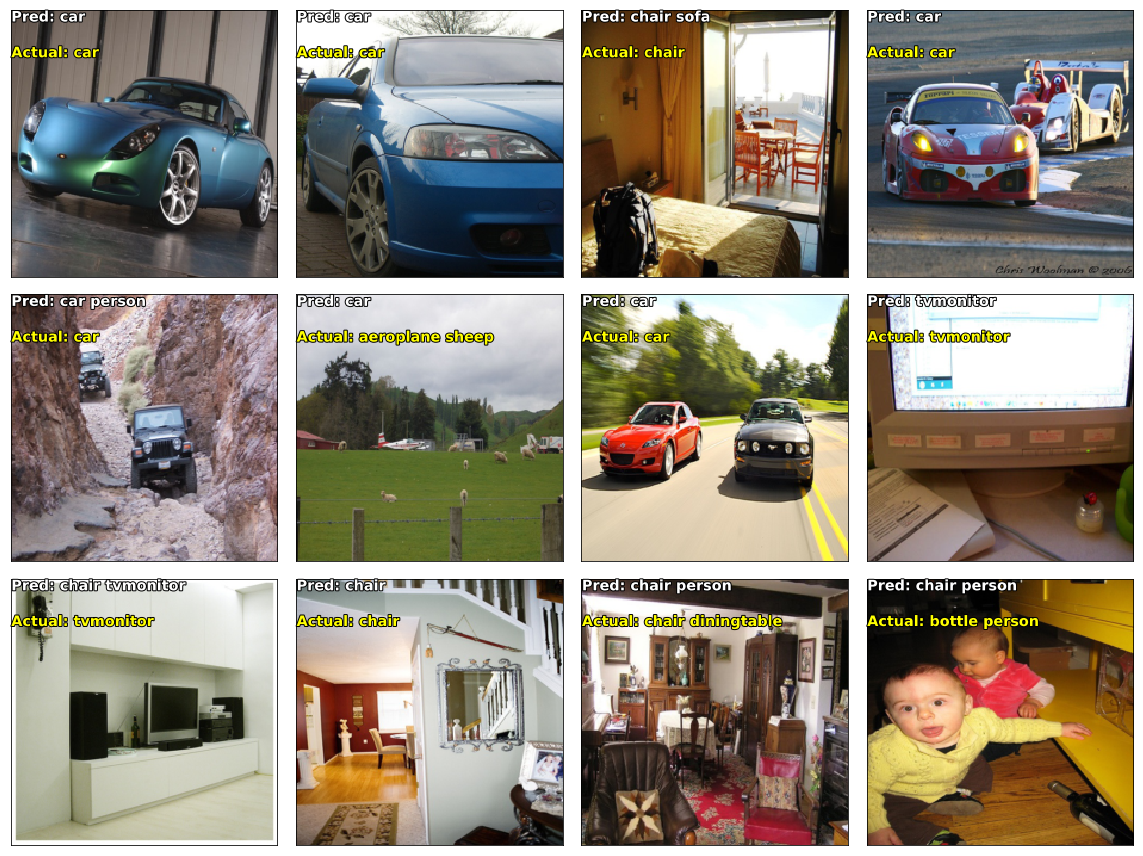

In [11]:
plot_utils.plot_model_predictions_on_sample_batch(batch, pred_label_logits, label_logits, 
                                                        pas_multi_train_dl.dataset.get_cat_labels)

In [18]:
#predictions, actual_instances, correct_predictions = get_class_wise_metrics(model, pas_multi_val_dl, pred_threshold)

#torch.save((predictions, actual_instances, correct_predictions), './Saved Tensors/class_wise_metrics_on_val_ds.pt')

predictions, actual_instances, correct_predictions = torch.load('./Saved Tensors/class_wise_metrics_on_val_ds.pt')

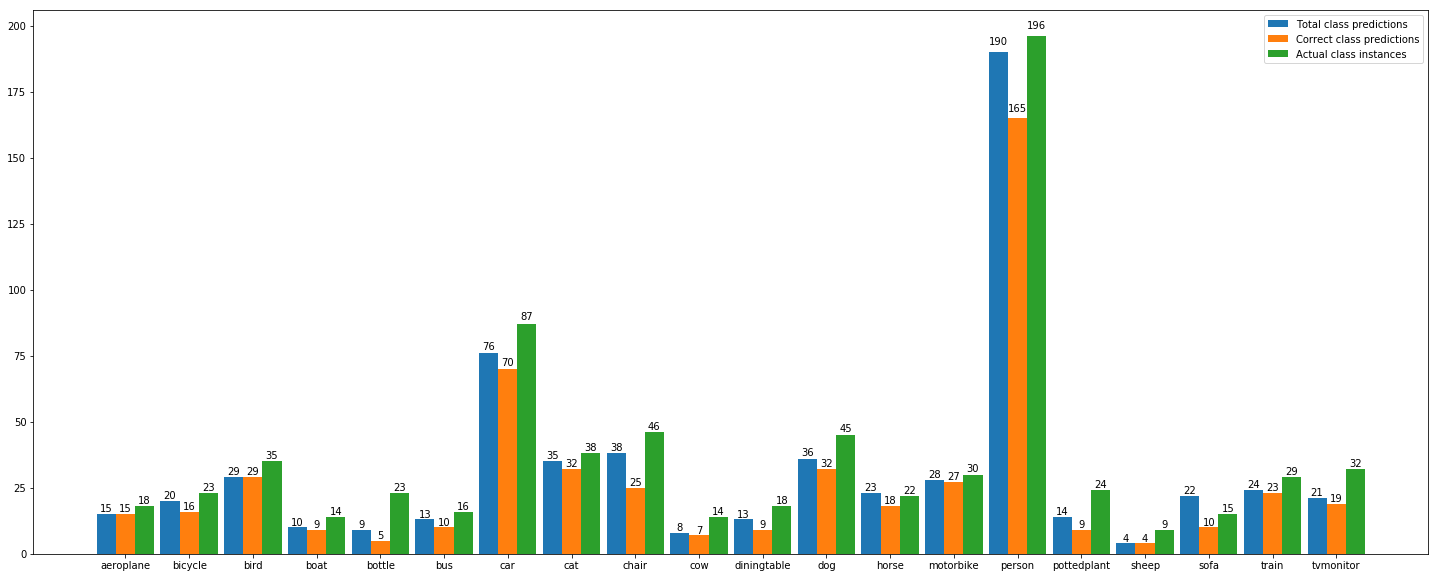

In [21]:
cats = list(pas_multi_train_dl.dataset.id_to_cat.values())
n_classes = len(cats)
plot_utils.plot_class_wise_preds_gt_true_preds(predictions, actual_instances, correct_predictions, cats)    

In [24]:
#ds_pred_scores, ds_gt_label_logits = get_concat_pred_scores_and_label_logits(model, pas_multi_val_dl)

#torch.save((ds_pred_scores, ds_gt_label_logits), './Saved Tensors/val_ds_pred_scores_and_label_logits.pt')

ds_pred_scores, ds_gt_label_logits = torch.load('./Saved Tensors/val_ds_pred_scores_and_label_logits.pt')

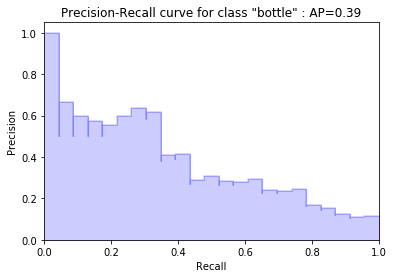

In [25]:
plot_utils.plot_class_precision_recall_curve(4, cats, ds_gt_label_logits, ds_pred_scores)    

In [26]:
precision, recall, average_precision = plot_utils.get_graph_data_for_multi_class_pr_curves(ds_gt_label_logits, ds_pred_scores, len(cats))

Average precision score, micro-averaged over all classes: 0.87


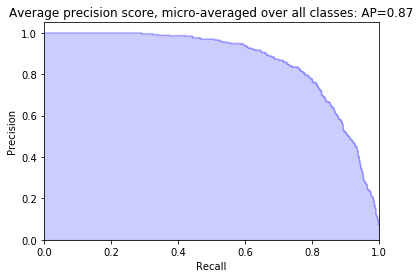

In [27]:
plot_utils.plot_average_precision_score_over_all_classes(precision, recall, average_precision)    

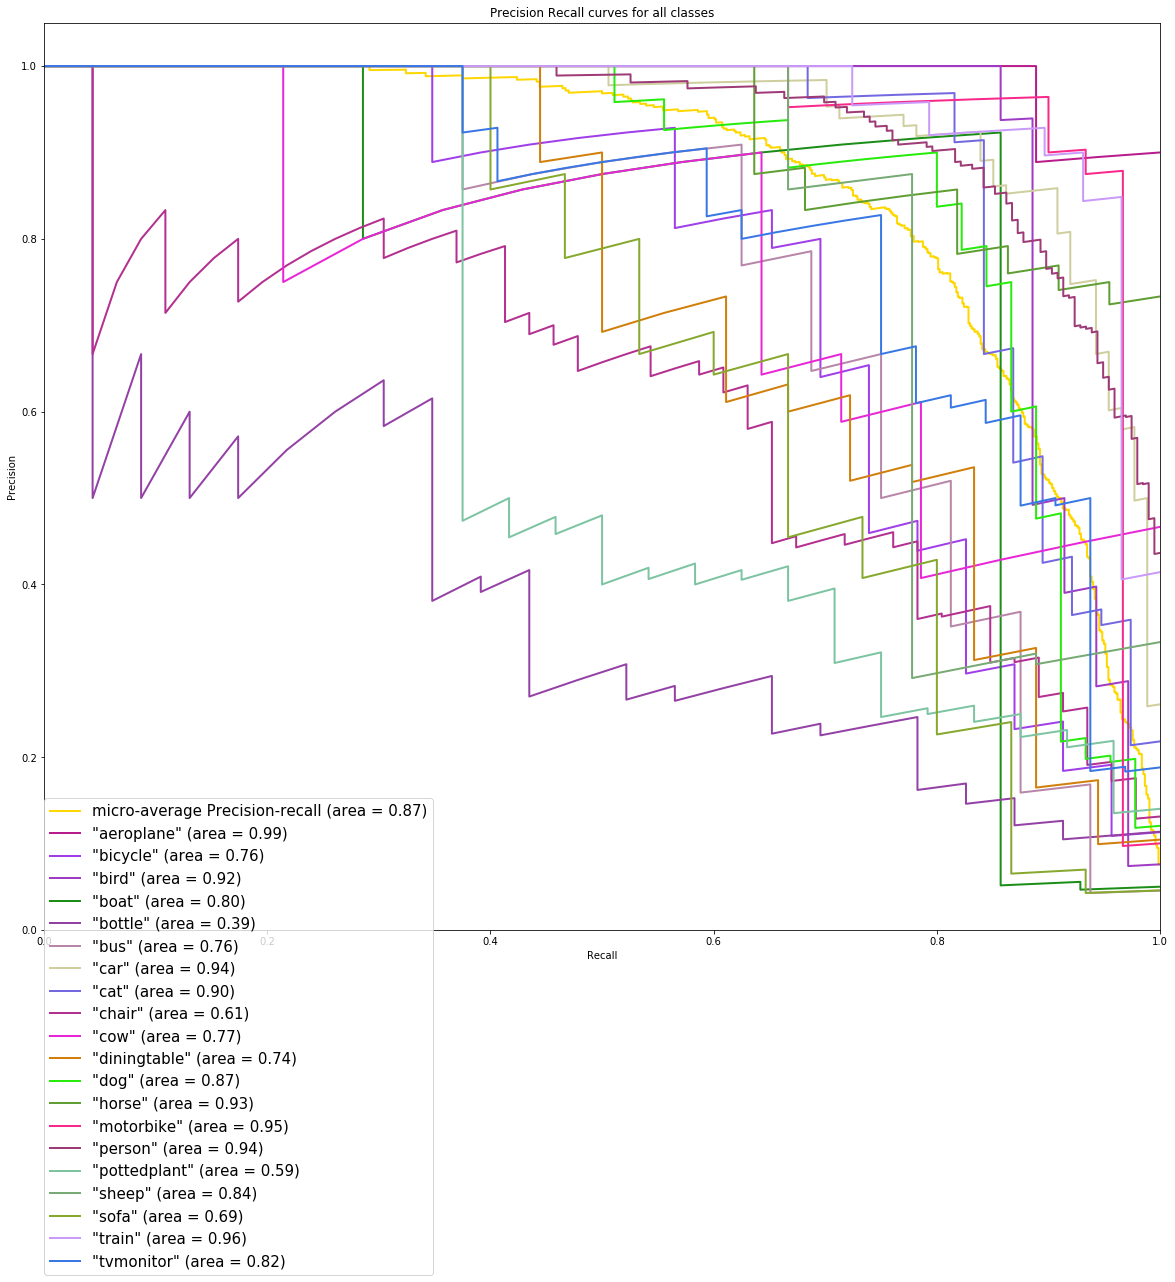

In [28]:
plot_utils.plot_precision_recall_curves_for_multi_class_labels(precision, recall, average_precision, cats)

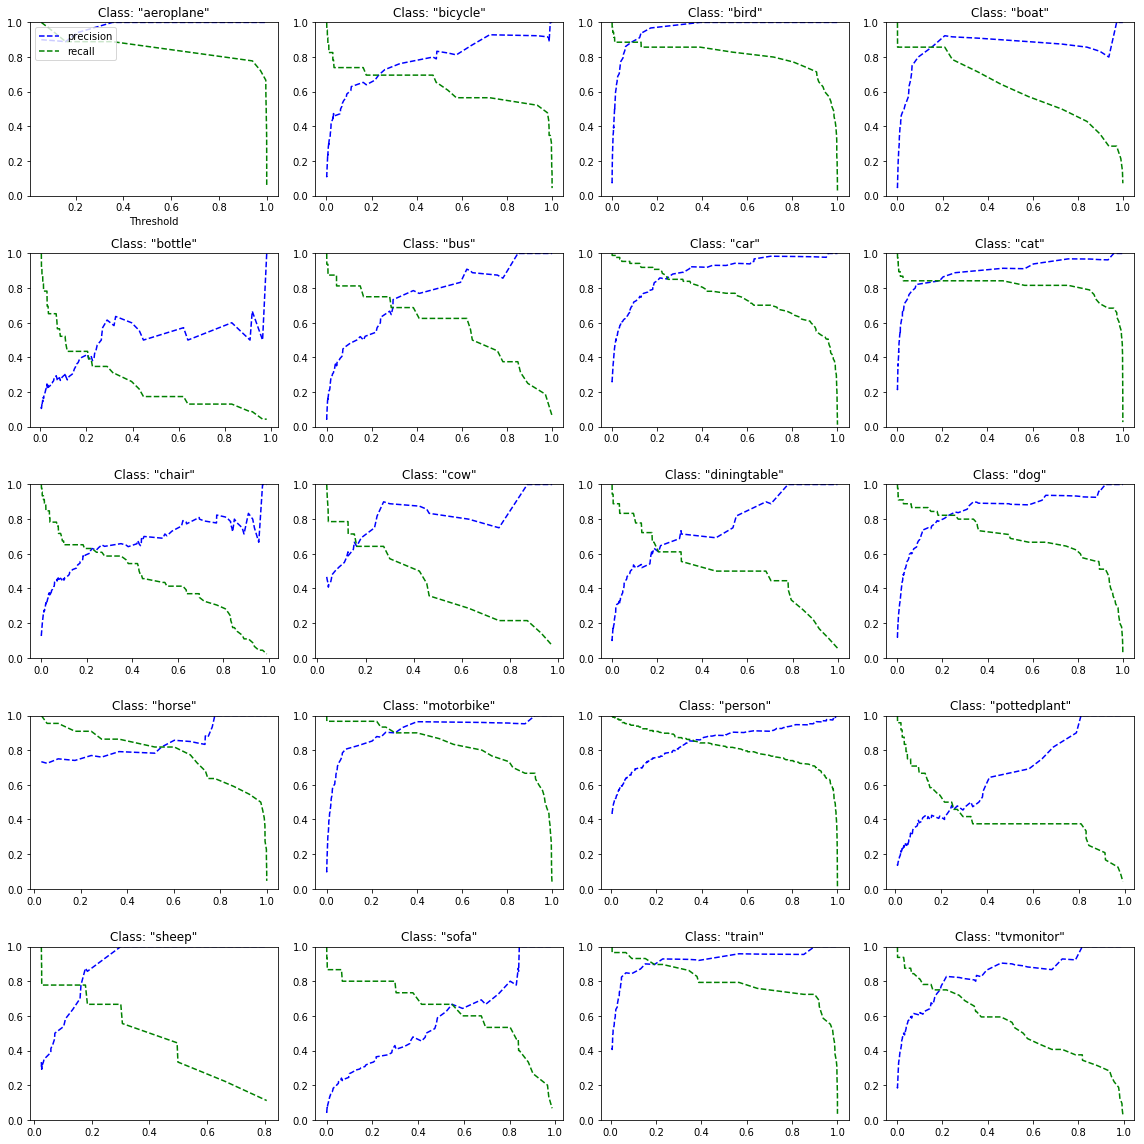

In [29]:
plot_utils.plot_precision_recall_vs_threshold_for_all_classes(n_classes, ds_gt_label_logits, ds_pred_scores, cats)